In [11]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from plotting_constants import gif_length, fps, carrier_colors, nice_names
from plotting_constants import color_dict as cost_factor_colors
from plotting_constants import width_unit, height_unit

In [4]:
carrier_colors['interconnector'] = 'plum'


In [5]:
day = '2024-03-21'
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'bmus_prepared.csv',
    index_col=0,
    )

bmus = bmus.loc[bmus['lat'] != 'distributed']

bmus['lat'] = bmus['lat'].apply(lambda x: np.around(float(x), 4))
bmus['lon'] = bmus['lon'].apply(lambda x: np.around(float(x), 4))

# bmus


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pypsa

def create_aggregated_timeseries(network, carrier_colors):
    ac_buses = network.buses.index[network.buses.carrier == "AC"]
    gen = network.generators[network.generators.bus.isin(ac_buses)]
    if not gen.empty:
        gen_ts = network.generators_t.p[gen.index]
        gen_ts_grouped = gen_ts.groupby(gen.carrier, axis=1).sum()

    else:
        gen_ts_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])
    stor = network.storage_units[network.storage_units.bus.isin(ac_buses)]
    if not stor.empty:
        stor_ts = network.storage_units_t.p[stor.index]
        stor_ts_grouped = stor_ts.groupby(stor.carrier, axis=1).sum()
    else:
        stor_ts_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])
    links = network.links
    link_contrib = pd.DataFrame(0, index=network.snapshots, columns=links.index)
    for link in links.index:
        bus0 = links.loc[link, "bus0"]
        bus1 = links.loc[link, "bus1"]
        p = network.links_t.p0[link]

        if bus0 in ac_buses and bus1 not in ac_buses:
            link_contrib[link] = -p
        elif bus1 in ac_buses and bus0 not in ac_buses:
            link_contrib[link] = p

    if not links.empty:
        if 'carrier' in links.columns:
            link_contrib_grouped = link_contrib.groupby(links.carrier, axis=1).sum()
        else:
            link_contrib.columns = ["interconnector"] * len(link_contrib.columns)
            link_contrib_grouped = link_contrib.groupby(axis=1, level=0).sum()
    else:
        link_contrib_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])

    all_carriers = list(set(gen_ts_grouped.columns).union(stor_ts_grouped.columns).union(link_contrib_grouped.columns))

    combined = pd.DataFrame(0, index=network.snapshots, columns=all_carriers)
    for df in [gen_ts_grouped, stor_ts_grouped, link_contrib_grouped]:
        for col in df.columns:
            combined[col] = combined[col] + df[col]

    sorted_cols = [carrier for carrier in carrier_colors.keys() if carrier in combined.columns]
    remaining = [carrier for carrier in combined.columns if carrier not in sorted_cols]

    combined = combined[sorted_cols + remaining].mul(1e-3)

    sort_order = combined.var().sort_values().index
    neg = combined[combined <= 0].replace(np.nan, 0)[sort_order]
    pos = combined[combined > 0].replace(np.nan, 0)[sort_order]

    return pos, neg


def animate_generation_mix(
        network,
        carrier_colors,
        gif_length_sec=10,
        fps=25,
        output_filename="generation_mix.gif"
        ):

    pos, neg = create_aggregated_timeseries(network, carrier_colors)

    x_times = (pos.index - pos.index[0]).total_seconds() / 3600.0
    carriers = pos.columns.tolist()

    y_data_pos = [pos[carrier].values for carrier in carriers]
    y_data_neg = [neg[carrier].values for carrier in carriers]

    fig, ax = plt.subplots(figsize=(2*width_unit, height_unit))

    # ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Power (GW)")
    # ax.set_title("Generation Mix Over a Day")

    colors = [carrier_colors.get(carrier, None) for carrier in carriers]

    stack_kwargs = {
        'linewidth': 0.5,
        'edgecolor': 'black',
        'alpha': 0.9,
    }

    ax.stackplot(x_times, y_data_pos, labels=carriers, colors=colors, **stack_kwargs)
    ax.stackplot(x_times, y_data_neg, labels=carriers, colors=colors, **stack_kwargs)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # ax.legend(loc="upper left")
    ax.set_xlim(0, 23)
    vline = ax.axvline(x=0, color="k", linestyle="-", linewidth=1.5)
    total_frames = int(gif_length_sec * fps)
    x_positions = np.linspace(0, 24, total_frames)

    from matplotlib.ticker import LinearLocator
    ax.xaxis.set_major_locator(LinearLocator(5))

    ax.set_xticks([0, 5.75, 11.5, 17.25, 23])
    ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'])

    def update(frame):
        vline.set_xdata([x_positions[frame]])
        return [vline]

    # plt.show()
    # import sys
    # sys.exit()

    

    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=True, interval=1000/fps)

    fig.tight_layout()
    ani.save(output_filename, writer="pillow", fps=fps)
    plt.close(fig)
    print(f"Saved GIF to {output_filename}")


In [7]:
n = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)

output_filename = "generation_mix.gif"

animate_generation_mix(
    n,
    carrier_colors,
    gif_length_sec=gif_length,
    fps=fps,
    output_filename=output_filename,
    )

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
C:\Users\lukas\AppData\Local\Temp\ipykernel_29964\3449972560.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gen_ts_grouped = gen_ts.groupby(gen.carrier, axis=1).sum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_29964\3449972560.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  stor_ts_grouped = stor_ts.groupby(stor.carrier, axis=1).sum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_29964\3449972560.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  link_contrib_grouped = link_contrib.groupby(links.carrier, axis=1).sum()
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Saved GIF to generation_mix.gif


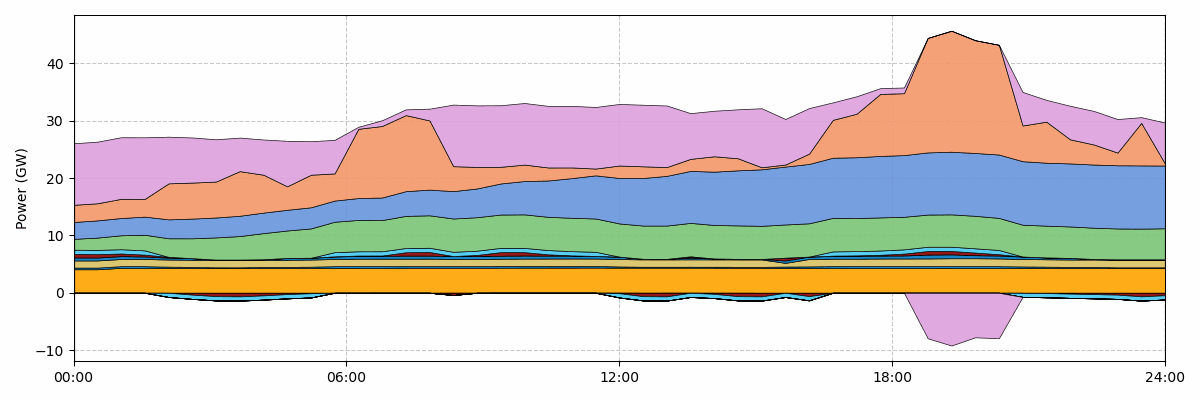

In [8]:
from IPython.display import Image, display
display(Image(filename=output_filename))

##### Consumer Payments Plot

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates


def animate_timeseries(
        df,
        column_colors,
        gif_length_sec=10,
        fps=25,
        output_filename="timeseries_animation.gif"
        ):
    """
    Creates a line plot for each column in the dataframe and animates a vertical dashed line
    moving smoothly across the plot to highlight different times of the day.

    Parameters:
      df              : pandas DataFrame with a datetime index (one day) and one or more columns.
      column_colors   : dict mapping each column name to a color (e.g., {"Series1": "blue", ...}).
      gif_length_sec  : desired total length of the gif in seconds.
      fps             : frames per second for the animation.
      output_filename : filename to save the resulting gif.
    """

    df = df.copy()
    df.index = range(0, 24)
    # Calculate total frames from gif length and fps.
    total_frames = int(gif_length_sec * fps)
    
    # Convert the first and last datetime in the index to Matplotlib date numbers.
    # x_start = mdates.date2num(df.index[0])
    # x_end = mdates.date2num(df.index[-1])
    x_start = df.index[0]
    x_end = df.index[-1]
    
    # Create an array of x positions (in date number format) for each frame.
    x_positions = np.linspace(x_start, x_end, total_frames)
    
    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(2*width_unit, height_unit))
    
    # Plot each timeseries line with its assigned color.
    for col in df.columns:
        color = column_colors.get(col, None)  # if not in dict, Matplotlib will assign a default
        ax.plot(df.index, df[col], label=nice_names[col], color=color, linewidth=2)


    
    # Format the x-axis to show ticks at 6-hour intervals in HH:MM format.
    # This uses Matplotlib's date locators and formatters.
    # ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0,6,12,18]))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    from matplotlib.ticker import LinearLocator
    ax.xaxis.set_major_locator(LinearLocator(5))

    ax.set_xticks([0, 5.75, 11.5, 17.25, 23])
    ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'])

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add axis labels, title, and a legend.
    # ax.set_xlabel("Time")
    ax.set_ylabel("Hourly Consumer Cost (m£)")
    # ax.set_title("Time Series Over One Day")
    ax.legend(
        bbox_to_anchor=(1, -0.3),
        loc='lower right',
        # borderaxespad=0.,
        # fontsize=12,
        frameon=False,
        ncol=len(df.columns) // 2,
    )
    
    # Draw an initial vertical dashed line at the leftmost time.
    # We convert the first date number back to a datetime.
    # vline = ax.axvline(x=mdates.num2date(x_positions[0]), color='k', linestyle='-', linewidth=1.5)
    vline = ax.axvline(x=x_positions[0], color='k', linestyle='-', linewidth=1.5)
    ax.set_xlim(0, 23)

    fig.tight_layout()

    # plt.show()
    # import sys
    # sys.exit()
    
    # Define the update function for the animation.
    def update(frame):
        # Convert the current x position (in date number) to a datetime.
        new_x = mdates.num2date(x_positions[frame])
        # The vertical line's x data should be a pair of identical x values (for a vertical line).
        vline.set_xdata([new_x, new_x])
        return [vline]
    
    # Create the animation.
    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=True, interval=1000/fps)
    
    # Adjust layout so that labels are not cut off.
    
    # Save the animation as a gif using the pillow writer.
    ani.save(output_filename, writer="pillow", fps=fps)
    plt.close(fig)
    print(f"Animation saved as {output_filename}")


In [10]:
import pandas as pd

idx = pd.IndexSlice

df = pd.read_csv(
    f'../results/{day}/system_cost_summary_flex.csv',
    index_col=[0,1],
    parse_dates=True,
    )

df = df.loc[df.index.get_level_values(1) != 'balancing_volume', 'national'].unstack().resample('H').sum()

out_filename = "consumer_cost_ts.gif"
animate_timeseries(
    df,
    cost_factor_colors,
    gif_length_sec=gif_length,
    fps=fps,
    output_filename=out_filename
    )

C:\Users\lukas\AppData\Local\Temp\ipykernel_29964\3885208445.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
C:\Users\lukas\AppData\Local\Temp\ipykernel_29964\3885208445.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.loc[df.index.get_level_values(1) != 'balancing_volume', 'national'].unstack().resample('H').sum()
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Animation saved as consumer_cost_ts.gif


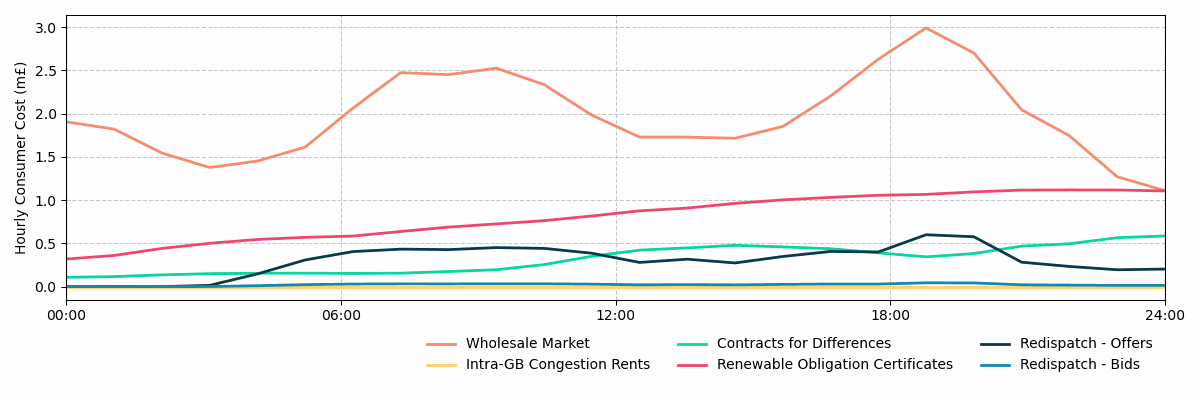

In [11]:
from IPython.display import Image, display
display(Image(filename=out_filename))

##### Dispatch on map

In [1]:
day = '2024-03-21'

In [3]:
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
from pathlib import Path

bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'bmus_prepared.csv',
    index_col=0,
    )

bmus = bmus.loc[bmus['lat'] != 'distributed']

bmus['lat'] = bmus['lat'].apply(lambda x: np.around(float(x), 4))
bmus['lon'] = bmus['lon'].apply(lambda x: np.around(float(x), 4))

n = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)
bal = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved_redispatch.nc'
)

# regions = gpd.read_file(Path.cwd().parent / '')

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads


In [48]:
def get_network_dispatch(n):

    ics = n.links.index[n.links.carrier == 'interconnector']

    d = pd.concat((
        n.generators_t.p, 
        n.links_t.p0.loc[:, ics],
        n.storage_units_t.p,
        ),
        axis=1,
        )

    mask = d.columns.str.contains('local_market')
    return d.loc[:, ~mask]

dispatch = get_network_dispatch(n)

found_locs = dispatch.columns.intersection(bmus.index)
nonfound_locs = dispatch.columns.difference(found_locs)

In [49]:
carriers = pd.concat((
    bmus.loc[found_locs, 'carrier'],
    pd.Series('interconnector', index=nonfound_locs)
))

In [7]:
bus_locs = bal.buses.loc[bal.links.loc[nonfound_locs, 'bus1'], ['x', 'y']].rename(
    columns={
    'x': 'lon', 'y': 'lat'
})
bus_locs.index = nonfound_locs

In [8]:
locs = pd.concat((
    bus_locs,
    bmus.loc[found_locs, ['lon', 'lat']]
)).rename(columns={'lon': 'x', 'lat': 'y'})

In [9]:
regions = gpd.read_file(Path.cwd().parent / 'data' / 'gb_shape.geojson')


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def animate_scatter(
        size_df,
        coords_df,
        carriers,
        regions,
        carrier_colors,
        fps,
        total_length,
        output_filename,
        ):
    """
    Creates and saves a gif animation of a scatterplot where point sizes vary over time.
    
    Parameters:
      size_df: pandas DataFrame
          Time series data with index as time and each column representing one point.
          The cell values determine the size (area) of the point.
      coords_df: pandas DataFrame
          DataFrame with each row corresponding to a point (index matching size_df columns)
          and with columns 'x' and 'y' for its coordinates.
      carriers: pandas Series
          Series indexed by point name (same as size_df.columns) whose values are used to
          determine the point's color.
      fps: int or float
          Frames per second for the resulting gif.
      total_length: int or float
          Total length of the gif in seconds.
      output_filename: str
          The filename for the saved gif (e.g., "animation.gif").
    """
    # Total number of frames to generate
    num_frames = int(fps * total_length)
    # If size_df has a different number of time steps, sample indices evenly.
    indices = np.linspace(0, len(size_df) - 1, num_frames).astype(int)
    
    # Set up the figure and axis.
    fig, ax = plt.subplots(figsize=(width_unit, 2*height_unit))
    plt.tight_layout()

    # regions.plot(ax=ax, color='lightgrey', alpha=0.5, edgecolor='black', linewidth=0.5)
    
    # The points (columns) from the size_df.
    points = size_df.columns
    
    # Get x and y coordinates for each point (make sure the order matches size_df.columns).
    xs = coords_df.loc[points, 'x'].values
    ys = coords_df.loc[points, 'y'].values
    
    # Determine colors for each point from the carriers Series.
    # If the carriers are numeric, use a continuous colormap.
    if pd.api.types.is_numeric_dtype(carriers):
        norm = Normalize(vmin=carriers.min(), vmax=carriers.max())
        cmap = cm.viridis
        # point_colors = np.array([cmap(norm(carrier_colors[carriers[pt]])) for pt in points])
        point_colors = np.array([carrier_colors[carriers[pt]] for pt in points])
    else:
        # Otherwise assume carriers are categorical.
        unique_categories = carriers.unique()
        # Use a discrete colormap (e.g. tab10) to assign colors.
        color_map = {cat: plt.cm.tab10(i % 10) for i, cat in enumerate(unique_categories)}
        # point_colors = np.array([color_map[carrier_colors[carriers[pt]]] for pt in points])
        point_colors = np.array([carrier_colors[carriers[pt]] for pt in points])
    
    # Create two scatter objects:
    #  - scat_pos for points with nonnegative values (drawn as filled circles)
    #  - scat_neg for points with negative values (drawn as hollow circles, with colored edges)
    # scat_pos = ax.scatter([], [], s=[], c=[], marker='o', edgecolors='none')
    # scat_neg = ax.scatter([], [], s=[], c=[], marker='o', facecolors='none', edgecolors='black', linewidths=1.5)
    
    # Set plot limits with a margin.
    margin = 1
    ax.set_xlim(coords_df['x'].min() - margin, coords_df['x'].max() + margin)
    ax.set_ylim(coords_df['y'].min() - margin, coords_df['y'].max() + margin)
    # ax.set_xlabel("X")
    # ax.set_ylabel("Y")
    # ax.set_title("Scatter Animation")
    ax.set_axis_off()
    
    # Choose a scale factor to adjust marker sizes (you may want to tweak this).
    sqrt_scale_factor = 50
    scale_factor = 2

    # plt.show()
    # import sys
    # sys.exit()

    def update(frame):
        # Get the data for the current frame.
        row = size_df.iloc[indices[frame]]
        # Compute sizes (marker area) from the absolute values.
        # We use sqrt so that the plotted radius scales with sqrt(value).
        # sizes = sqrt_scale_factor * np.sqrt(np.abs(row.values))
        sizes = scale_factor * np.abs(row.values)
        
        # Separate positive (and zero) and negative values.
        pos_mask = row.values >= 0
        neg_mask = row.values < 0

        # For positive values: use filled markers.
        xs_pos = xs[pos_mask]
        ys_pos = ys[pos_mask]
        sizes_pos = sizes[pos_mask]
        colors_pos = point_colors[pos_mask]
        
        # For negative values: use hollow markers (only edges colored).
        xs_neg = xs[neg_mask]
        ys_neg = ys[neg_mask]
        sizes_neg = sizes[neg_mask]
        colors_neg = point_colors[neg_mask]

        for coll in ax.collections[:]:
            coll.remove()

        regions.plot(ax=ax, color='lightgrey', alpha=0.5, edgecolor='black', linewidth=0.5)
        
        scat_pos = ax.scatter(
            xs_pos,
            ys_pos,
            s=sizes_pos,
            c=colors_pos,
            alpha=0.5,
            # marker='o',
            # edgecolors='none',
            # markerfacecolor='none',
            )

        scat_pos = ax.scatter(
            xs_pos,
            ys_pos,
            s=sizes_pos,
            # c=colors_pos,
            marker='o',
            facecolors='none',
            edgecolors=colors_pos,
            linewidths=1.,
            )

        scat_neg = ax.scatter(
            xs_neg,
            ys_neg,
            s=sizes_neg,
            # c=colors_neg,
            marker='o',
            facecolor='none',
            edgecolor=colors_neg,
            linewidths=1.5
            )
        
        return scat_pos, scat_neg

    # Create the animation.
    ani = FuncAnimation(fig, update, frames=num_frames, blit=True)
    
    # Save the animation as a GIF using Pillow.
    ani.save(output_filename, writer='pillow', fps=fps)
    
    # Optionally, close the figure.
    plt.close(fig)


# Example usage (you would replace these with your actual data):
if __name__ == '__main__':
    
    # Run the animation function.
    animate_scatter(
        # dispatch.iloc[:5,:],
        dispatch.resample('5min').mean().interpolate().iloc[:,:],
        locs,
        carriers,
        regions,
        carrier_colors,
        fps=fps,
        total_length=gif_length,
        output_filename='scatter_wholesale_animation.gif'
        )


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


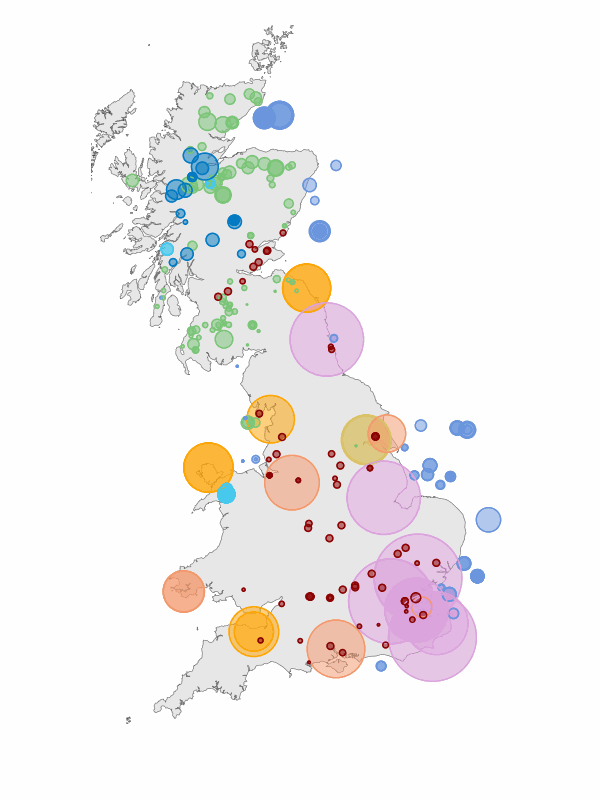

In [ ]:
from IPython.display import Image, display
display(Image(filename='scatter_wholesale_animation.gif'))

In [52]:
balancing_dispatch = get_network_dispatch(bal)
balancing = balancing_dispatch - dispatch.loc[:, balancing_dispatch.columns.intersection(dispatch.columns)]

In [53]:
animate_scatter(
    # dispatch.iloc[:5,:],
    balancing.resample('5min').mean().interpolate().iloc[:,:],
    locs,
    carriers,
    regions,
    carrier_colors,
    fps=fps,
    total_length=gif_length,
    output_filename='scatter_balancing_animation.gif'
    )

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


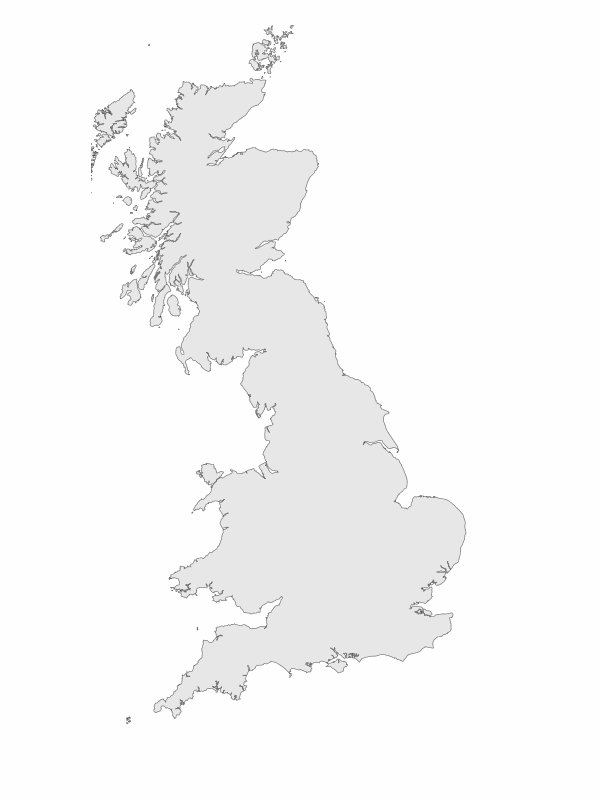

In [54]:
from IPython.display import Image, display
display(Image(filename='scatter_balancing_animation.gif'))